In [1]:
%pwd

'/Users/peiboxu/Desktop/merge-seq analysis/elife_revision/code_file'

In [2]:
import numpy as np
import pandas as pd
import scanpy as sc
import os
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import rcParams
%matplotlib inline

In [3]:
sc.settings.verbosity = 3  # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_versions()
sc.settings.set_figure_params(dpi=80, frameon=False,fontsize=10,dpi_save=300,format='pdf')  # low dpi (dots per inch) yields small inline figures
plt.rcParams['font.sans-serif']=['Arial']
plt.rcParams['pdf.fonttype'] = 'truetype'

-----
anndata     0.9.1
scanpy      1.9.3
-----
PIL                 9.5.0
anyio               NA
appnope             0.1.3
arrow               1.2.3
asttokens           NA
attr                23.1.0
babel               2.12.1
backcall            0.2.0
certifi             2023.05.07
cffi                1.15.1
charset_normalizer  3.1.0
comm                0.1.3
cycler              0.10.0
cython_runtime      NA
dateutil            2.8.2
debugpy             1.6.7
decorator           5.1.1
defusedxml          0.7.1
executing           1.2.0
fastjsonschema      NA
fqdn                NA
h5py                3.9.0
idna                3.4
importlib_resources NA
ipykernel           6.23.3
ipython_genutils    0.2.0
ipywidgets          8.0.6
isoduration         NA
jedi                0.18.2
jinja2              3.1.2
joblib              1.3.0
json5               NA
jsonpointer         2.4
jsonschema          4.17.3
jupyter_events      0.6.3
jupyter_server      2.7.0
jupyterlab_server   2.23.0
kiwis

# Subset excitatory neuron

In [87]:
adata=sc.read_h5ad( './write/pfc_seurat_merge_anno.h5ad')

In [92]:
# how many cells are from FACSorting
adata.obs['facs'].value_counts()

unsort    19470
sort       1791
Name: facs, dtype: int64

In [ ]:
### subset excitatory neuron
bdata = adata[adata.obs['louvain_coarse'].isin(['Excitatory'])].copy()
bdata

In [ ]:
sc.pp.filter_genes(bdata, min_cells=3)

In [9]:
# export meta info and filtered genes for seurat processing
bdata.obs.to_csv('sub_exn_meta.csv')
bdata.var.to_csv('sub_exn_vars.csv')

# Processing in Seurat

In [ ]:
#See R scripts, 
### step 3 ###
### 3_filtering_in_seurat
### Analysis on Excitatory neuron  ###

In [ ]:
# PART2 3-6

# Import loom file processed by Seurat

In [41]:
## read loom file for first time, next time, load h5ad file

bdata=sc.read_loom('/home/xupb/scRNA_data/mouse_pfc/manuscripts/pfc_exn_sub.loom')


/home/xupb/anaconda3/envs/myenv/lib/python3.7/site-packages/loompy/loom_layer.py:123: RuntimeWarning: invalid value encountered in not_equal
  nonzeros = np.where(vals != 0)


In [42]:
bdata

AnnData object with n_obs × n_vars = 10005 × 19605 
    obs: 'ClusterID', 'ClusterName', 'G2M_Score', 'Phase', 'S_Score', 'facs', 'nCount_RNA', 'nFeature_RNA', 'old_ident', 'orig_ident', 'percent_mt', 'percent_rp', 'sample'
    var: 'Selected', 'vst_mean', 'vst_variable', 'vst_variance', 'vst_variance_expected', 'vst_variance_standardized'
    obsm: 'pca_cell_embeddings', 'tsne_cell_embeddings', 'umap_cell_embeddings'
    varm: 'pca_feature_loadings'
    layers: 'norm_data', 'scale_data'

In [43]:
bdata.obsm['X_pca']=bdata.obsm['pca_cell_embeddings']

In [44]:
bdata.var['highly_variable']=bdata.var['Selected'].astype('bool')

In [45]:
results_file = './write/pfc_sub_seu.h5ad'
bdata.write(results_file) 

... storing 'ClusterName' as categorical
... storing 'Phase' as categorical
... storing 'facs' as categorical
... storing 'old_ident' as categorical
... storing 'orig_ident' as categorical
... storing 'sample' as categorical


In [46]:
sc.pp.neighbors(bdata, n_neighbors=15, n_pcs=30)
sc.tl.umap(bdata)

computing neighbors
    using 'X_pca' with n_pcs = 30
    finished: added to `.uns['neighbors']`
    'distances', distances for each pair of neighbors
    'connectivities', weighted adjacency matrix (0:00:02)
computing UMAP


/home/xupb/anaconda3/envs/myenv/lib/python3.7/site-packages/umap/spectral.py:229: UserWarning: Embedding a total of 2 separate connected components using meta-embedding (experimental)
  n_components


    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:08)


In [50]:
sc.tl.leiden(bdata,resolution =0.3)

running Leiden clustering
    finished: found 15 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:01)


In [46]:
#sc.tl.tsne(bdata, n_pcs=50)

computing tSNE
    using 'X_pca' with n_pcs = 50
    using the 'MulticoreTSNE' package by Ulyanov (2017)
    finished: added
    'X_tsne', tSNE coordinates (adata.obsm) (0:01:04)


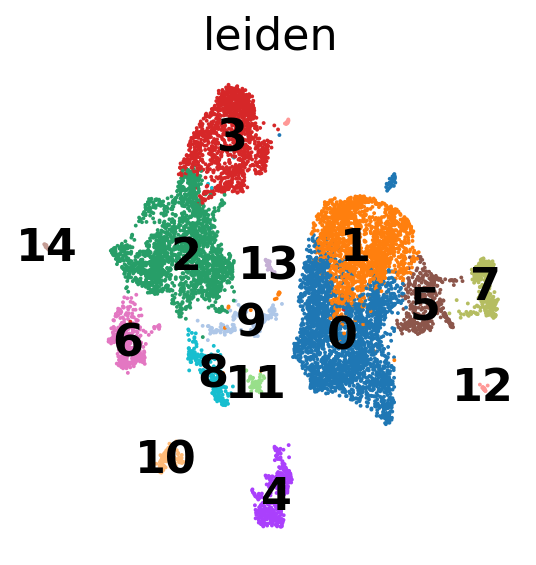

In [51]:
sc.pl.umap(bdata, color=['leiden'],
           use_raw=False,ncols=3,layer='norm_data',legend_loc='on data')

# check which cluster has low nCount_RNA, low nFeature_RNA and high MT percent

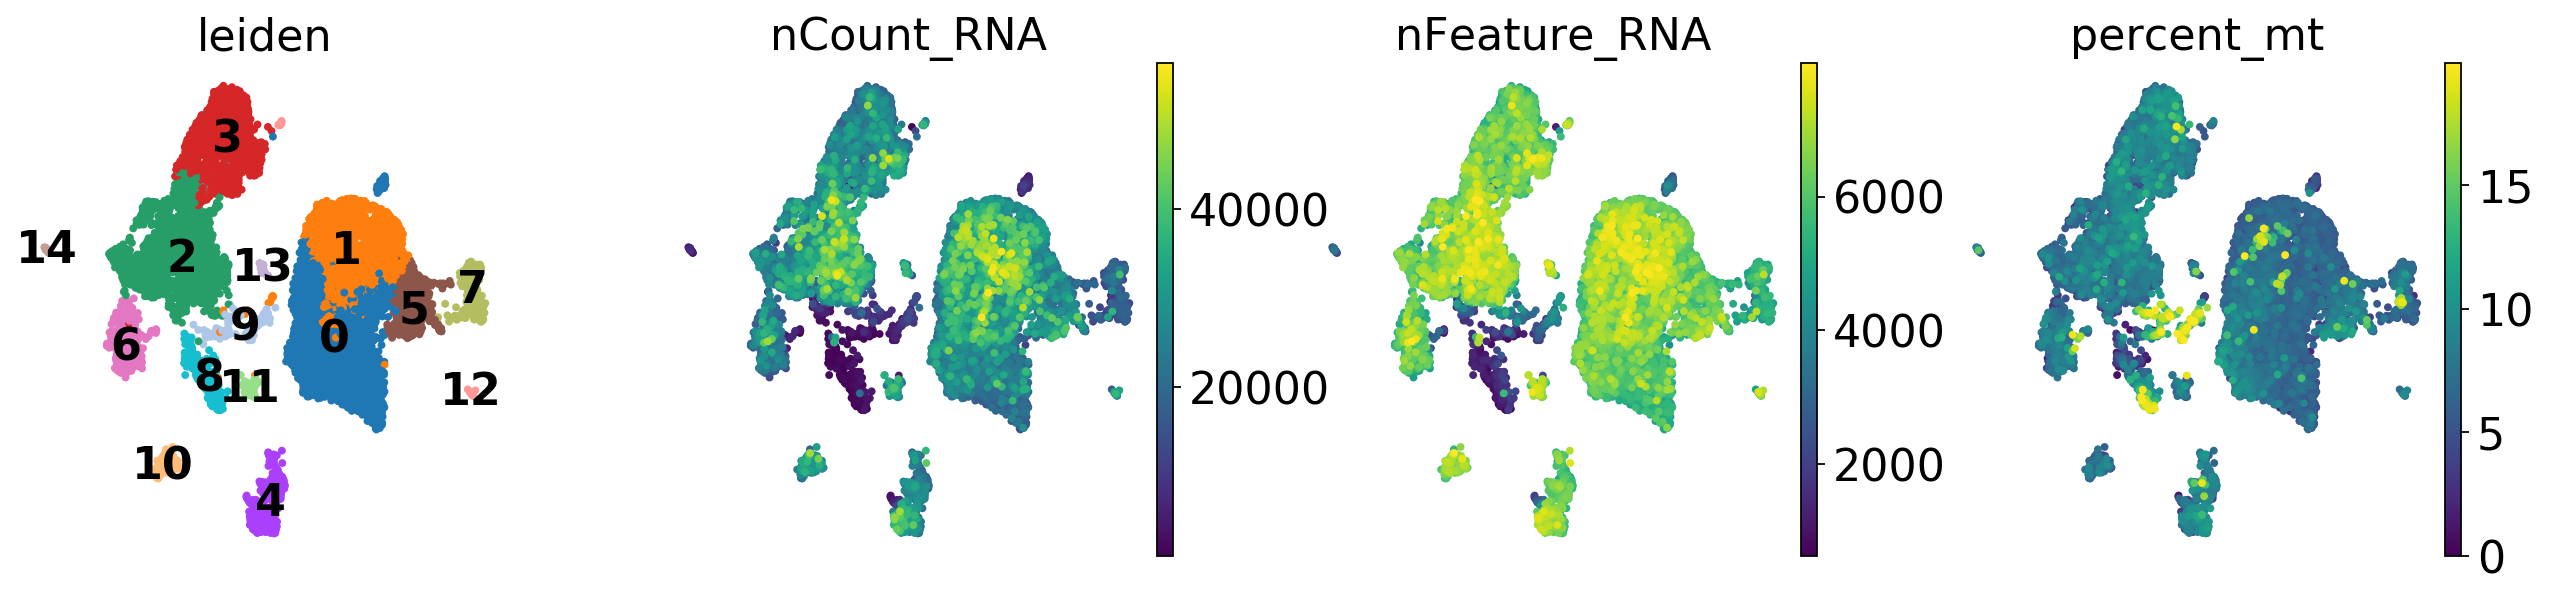

In [52]:
sc.pl.umap(bdata, color=['leiden','nCount_RNA', 'nFeature_RNA', 'percent_mt'],
           size=50,#L6
           use_raw=False,ncols=4,layer='norm_data',legend_loc='on data')#,save=' which cluster lowQ.png'

# Find DEGs for each cluster, do metascape analysis to determine which cluster is not excitatory neuron cluster

In [56]:
sc.tl.rank_genes_groups(bdata, 'leiden', method='wilcoxon',layer='norm_data',use_raw=False,n_genes=200)

ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:22)


In [54]:
pd.options.display.max_columns = None
# display max_columns setting
pd.DataFrame(bdata.uns['rank_genes_groups']['names']).head(50)

0         1              2          3              4  \
0            Pcp4       Ndn          Mef2c      C1ql3          Pex5l   
1   3110035E14Rik       Ubb          Epha4    Rasl10a         Pou3f1   
2           Ttc9b     Uchl1           Nrn1       Enc1          Rab3c   
3          Garnl3    Tuba1a          Nrsn1       Dgkb         Bcl11b   
4            Rprm  Hsp90ab1         Atp1b2    Galnt14          Lamp5   
5            Tle4     Gapdh           Cnr1       Tesc         Ppfia2   
6           Trbc2   Slc25a4           Fat3      Nptxr         Gabra2   
7          Rnf152  Hsp90aa1           Lmo4        Cck          Ntng1   
8           Rph3a      Mdh1         Vstm2l    Tsc22d1           Dner   
9           Efhd2   Slc25a3          Kcnq3      Nell2         Igfbp4   
10         Slc1a2     Itm2b        Camk2n1       Nnat          Timp2   
11         Ccdc12    Rwdd2a           Syt4      Ptprt          Lypd1   
12        Col12a1      Gnas        Slc24a3      Olfm1          Opcml   
13           Tbr1    Tubb2a        Fam19a1       Tpm1         Sphkap   
14         Hs3st4      Crym          Foxp1      Mgat5        Fam126a   
15         Snap25     Tusc3         Kcnab1      Vegfd         Tmem47   
16          Foxp2     Cyr61           Syn2   Trp53i11          Prkcg   
17          Calm2      Tecr           Syn1       Thra           Chn1   
18         Ccl27a     Ifi27          Car10       Bmp3        Bhlhe40   
19         Sema5a      Mdh2            Cck      Ptprk          Cdk17   
20         Ipcef1    Tagln3           Hrh3      Rxfp1        Slc4a10   
21          Plcb4     Itm2c         Stxbp1      Opcml       Cacna2d3   
22           Lmo1      Ldhb         R3hdm1   Sh3bgrl3         Stxbp6   
23        Pitpnc1     Actg1         Rimbp2     Igfbp6           Meg3   
24           Syt6     Aldoa          Robo2       Rgs2          Tiam1   
25         Nos1ap    Tubb4b          Nr2f1     Sorcs3          Vat1l   
26          Rprml    Uqcrc1         Camk2d     Tmsb4x          Crim1   
27         Adgra1    Dnaja1            Wls       Zeb2         Ppp1r2   
28           Pbx1   Atp6ap2          Kcnb2     Schip1        Fam19a1   
29          Pde4d     Dusp1            Ntm     Plxna4         Cadps2   
30          Ramp3     Psmd6          Cpne4      Tenm3         Zfp703   
31          Ncald     Npas4        Slc2a13     Col6a1          Pcdh8   
32          Nxph3    Uqcrc2          Fbxw7       Stum          Parm1   
33         Lpgat1     Psma4          Rims3  Adcyap1r1        Slc16a2   
34           Etl4     Atp5b           Pkib     Sema3e          Grik2   
35           Nrp1      Ppia        Slc30a3     Camkk1  1190002N15Rik   
36         Cxcl12      Rtn1          Nptxr      Unc5a          Caln1   
37         Ndufa4    Stk32c          Gfra2      Auts2        Rapgef5   
38         Pdzrn4     Psmb1           Syt1      Wipf3        Fam131a   
39         Adora1     Hspa8       Slc39a10     Sema3c           Bcl6   
40          Nrip3     Psmc2          Cnih3      Cdh13           Pak3   
41         Diras2     Tubb5  6430548M08Rik       Rhou        Fam135b   
42           Fut9    Tuba1b         Necab1      Kctd4          Syt17   
43         Plxna2      Cct7          Dkkl1     Pea15a           Hcn1   
44         Dynll1     Basp1           Hpca      Oprk1          Gria3   
45         B3gat1    Ndufv1           Nwd2    Pitpnm2        Adamts2   
46           Pfn2    Atxn10          Ajap1      Ccdc3          Kcng1   
47          Stmn1      Fdps           Wnt4    Ppp1r1a        Gm19410   
48         Hs3st2     Rraga       AI593442     Srgap3        Sec14l1   
49         Lrrtm2   Slc25a5          Rab3c       Gng2         Elmod1   

           5              6              7        8         9       10  \
0     Nap1l5          Calb1          Tshz2  Gm42418     Gria2     C1qb   
1     Slc1a2         Fkbp1a          Lypd1     Actb    Snhg11     C1qa   
2      Rcan2        Nectin3          Cbln2    Calm2    Malat1     C1qc   
3   Serpini1         Gabra2           Myl4     

In [57]:
pd.DataFrame(bdata.uns['rank_genes_groups']['names']).to_csv('rank_genes_groups_wilcoxon_pfc_subexn_leiden0.3_pc30.csv')

In [58]:
results_file = './write/pfc_sub_seu_unfilter.h5ad'
bdata.write(results_file) 

In [5]:
bdata=sc.read_h5ad( './write/pfc_sub_seu_unfilter.h5ad')

# Filter out lowQ and contamination cell cluster

In [59]:
bdata = bdata[bdata.obs['leiden'].isin(['0', '1', '2', '3', '4', '5', '6','7'])].copy()
bdata

AnnData object with n_obs × n_vars = 9368 × 19605 
    obs: 'ClusterID', 'ClusterName', 'G2M_Score', 'Phase', 'S_Score', 'facs', 'nCount_RNA', 'nFeature_RNA', 'old_ident', 'orig_ident', 'percent_mt', 'percent_rp', 'sample', 'leiden'
    var: 'Selected', 'vst_mean', 'vst_variable', 'vst_variance', 'vst_variance_expected', 'vst_variance_standardized', 'highly_variable'
    uns: 'neighbors', 'umap', 'leiden', 'leiden_colors', 'rank_genes_groups'
    obsm: 'pca_cell_embeddings', 'tsne_cell_embeddings', 'umap_cell_embeddings', 'X_pca', 'X_umap'
    varm: 'pca_feature_loadings'
    layers: 'norm_data', 'scale_data'

In [62]:
sc.pp.filter_genes(bdata, min_cells=3)

filtered out 211 genes that are detected in less than 3 cells


In [63]:
bdata.obs.to_csv('sub_exn_meta_filter_others.csv')

In [64]:
bdata.var.to_csv('sub_exn_vars_filter_others.csv')

In [65]:
bdata

AnnData object with n_obs × n_vars = 9368 × 19394 
    obs: 'ClusterID', 'ClusterName', 'G2M_Score', 'Phase', 'S_Score', 'facs', 'nCount_RNA', 'nFeature_RNA', 'old_ident', 'orig_ident', 'percent_mt', 'percent_rp', 'sample', 'leiden'
    var: 'Selected', 'vst_mean', 'vst_variable', 'vst_variance', 'vst_variance_expected', 'vst_variance_standardized', 'highly_variable', 'n_cells'
    uns: 'neighbors', 'umap', 'leiden', 'leiden_colors', 'rank_genes_groups'
    obsm: 'pca_cell_embeddings', 'tsne_cell_embeddings', 'umap_cell_embeddings', 'X_pca', 'X_umap'
    varm: 'pca_feature_loadings'
    layers: 'norm_data', 'scale_data'

# Processing in Seurat

In [ ]:
## see R scripts 
### step 5 ###
# run 3.2_filtering_in_seurat_lowq.R #
##############################


In [ ]:
# PART3 8-10

# Import file processed by Seurat

In [72]:
## read loom file for first time, next time, load h5ad file

 bdata=sc.read_loom('/home/xupb/scRNA_data/mouse_pfc/manuscripts/pfc_exn_sub_tirm.loom')

/home/xupb/anaconda3/envs/myenv/lib/python3.7/site-packages/loompy/loom_layer.py:123: RuntimeWarning: invalid value encountered in not_equal
  nonzeros = np.where(vals != 0)


In [74]:
bdata

AnnData object with n_obs × n_vars = 9368 × 19394 
    obs: 'ClusterID', 'ClusterName', 'G2M_Score', 'Phase', 'S_Score', 'facs', 'nCount_RNA', 'nFeature_RNA', 'old_ident', 'orig_ident', 'percent_mt', 'percent_rp', 'sample'
    var: 'Selected', 'vst_mean', 'vst_variable', 'vst_variance', 'vst_variance_expected', 'vst_variance_standardized'
    obsm: 'pca_cell_embeddings', 'tsne_cell_embeddings', 'umap_cell_embeddings'
    varm: 'pca_feature_loadings'
    layers: 'norm_data', 'scale_data'

In [83]:
bdata.obsm['X_pca']=bdata.obsm['pca_cell_embeddings']

In [84]:
bdata.var['highly_variable']=bdata.var['Selected'].astype('bool')

In [86]:
results_file = './write/pfc_sub_seu_trim.h5ad'
bdata.write(results_file) 

In [5]:
bdata=sc.read_h5ad('./write/pfc_sub_seu_trim.h5ad')

In [6]:
bdata

AnnData object with n_obs × n_vars = 9368 × 19394
    obs: 'ClusterID', 'ClusterName', 'G2M_Score', 'Phase', 'S_Score', 'facs', 'nCount_RNA', 'nFeature_RNA', 'old_ident', 'orig_ident', 'percent_mt', 'percent_rp', 'sample'
    var: 'Selected', 'vst_mean', 'vst_variable', 'vst_variance', 'vst_variance_expected', 'vst_variance_standardized', 'highly_variable'
    obsm: 'X_pca', 'pca_cell_embeddings', 'tsne_cell_embeddings', 'umap_cell_embeddings'
    varm: 'pca_feature_loadings'
    layers: 'norm_data', 'scale_data'

In [245]:
sc.pp.neighbors(bdata, n_neighbors=10, n_pcs=30)
sc.tl.umap(bdata)

computing neighbors
    using 'X_pca' with n_pcs = 30
    finished: added to `.uns['neighbors']`
    'distances', distances for each pair of neighbors
    'connectivities', weighted adjacency matrix (0:00:01)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:17)


In [246]:
sc.tl.leiden(bdata,resolution =0.3)

running Leiden clustering
    finished: found 9 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:00)


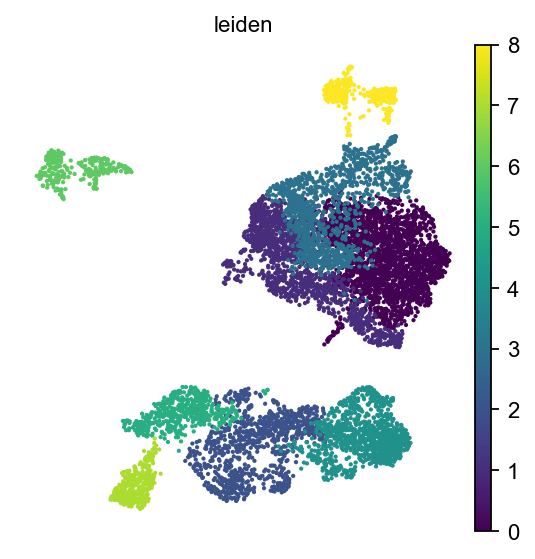

In [13]:
sc.pl.umap(bdata, color=['leiden'],use_raw=False,ncols=3,
           layer='norm_data',legend_loc='on data')

In [105]:
sc.tl.tsne(bdata, n_pcs=30)

computing tSNE
    using 'X_pca' with n_pcs = 30
    using the 'MulticoreTSNE' package by Ulyanov (2017)
    finished: added
    'X_tsne', tSNE coordinates (adata.obsm) (0:00:59)


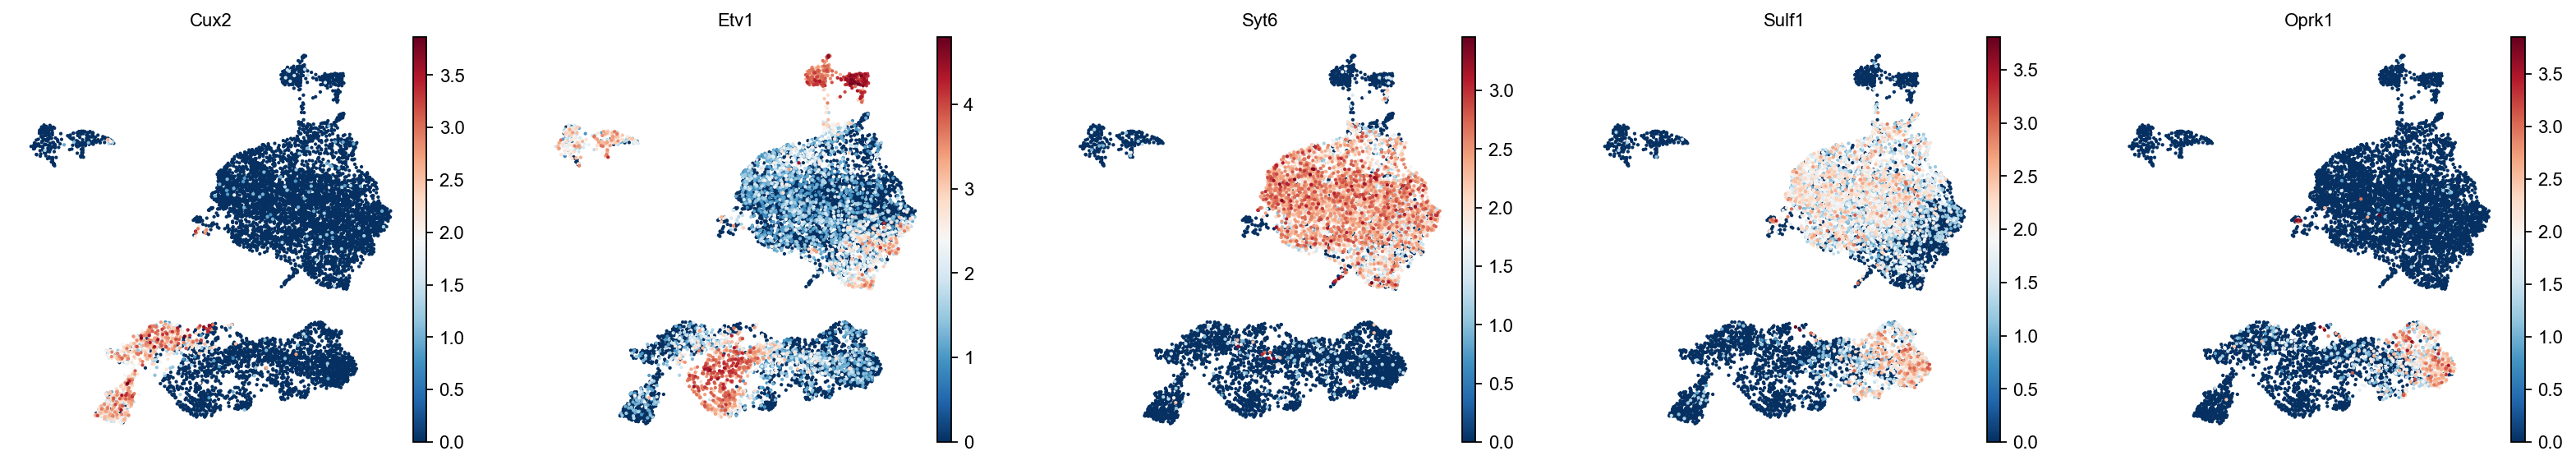

In [12]:
#check layer markers 
sc.pl.umap(bdata, color=["Cux2",#L2/3 c5 8
                         'Etv1',#L5, c3 7 9
                         "Syt6",'Sulf1',#L6, c0 1 4 6
                         'Oprk1',#L6, c2
                       ],
           use_raw=False,ncols=5,
           color_map='RdBu_r', 
           #vmin=-2, vmax=3,
           layer='norm_data',legend_loc='on data')

In [110]:
#### merge clusters, corase clustering by layer, this annotation defines 2 layer 6 clusters
bdata.obs['layer'] = bdata.obs['leiden']
old_to_new = {'0':'L6-Syt6','1':'L6-Syt6','3':'L6-Syt6',
              '4': 'L6-Oprk1',
              '5':'L2/3-Cux2','7':'L2/3-Cux2',
              '2':'L5-Etv1', '6':'L5-Etv1','8':'L5-Etv1'}
    
bdata.obs['layer'] = (
    bdata.obs['layer']
    .map(old_to_new)
    .astype('category')
)

In [159]:
#### merge clusters, corase clustering by layer, this annotation combines 2 layer 6 clusters into 1
bdata.obs['layer_v1'] = bdata.obs['leiden']
old_to_new = {'0':'L6-Sulf1','1':'L6-Sulf1','3':'L6-Sulf1',
              '4': 'L6-Sulf1',
              '5':'L2/3-Cux2','7':'L2/3-Cux2',
              '2':'L5-Etv1', '6':'L5-Etv1','8':'L5-Etv1'}
    
bdata.obs['layer_v1'] = (
    bdata.obs['layer_v1']
    .map(old_to_new)
    .astype('category')
)

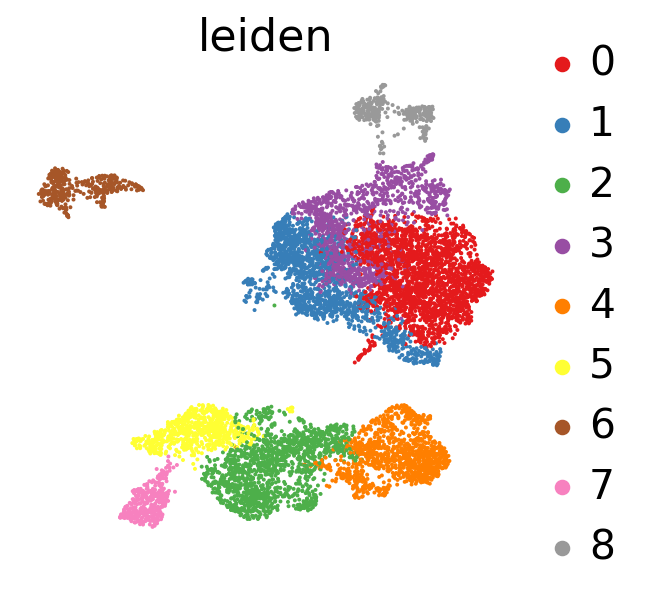

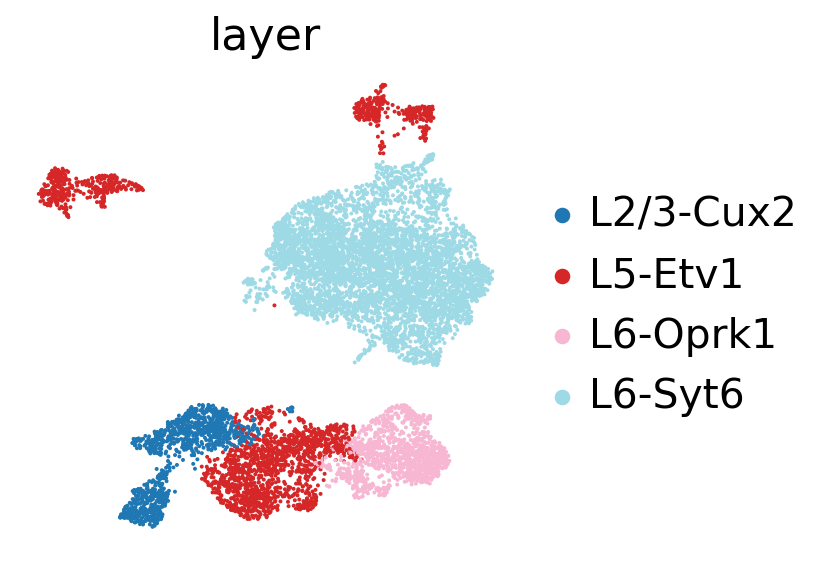

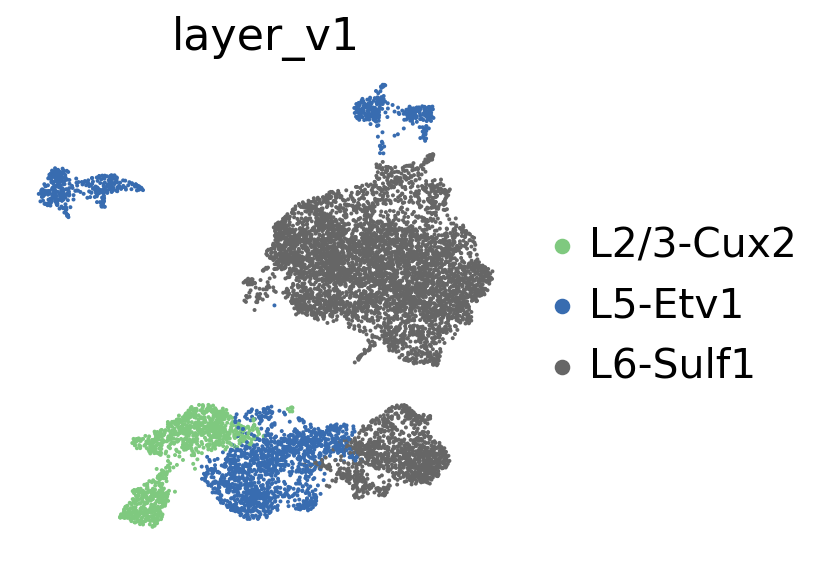

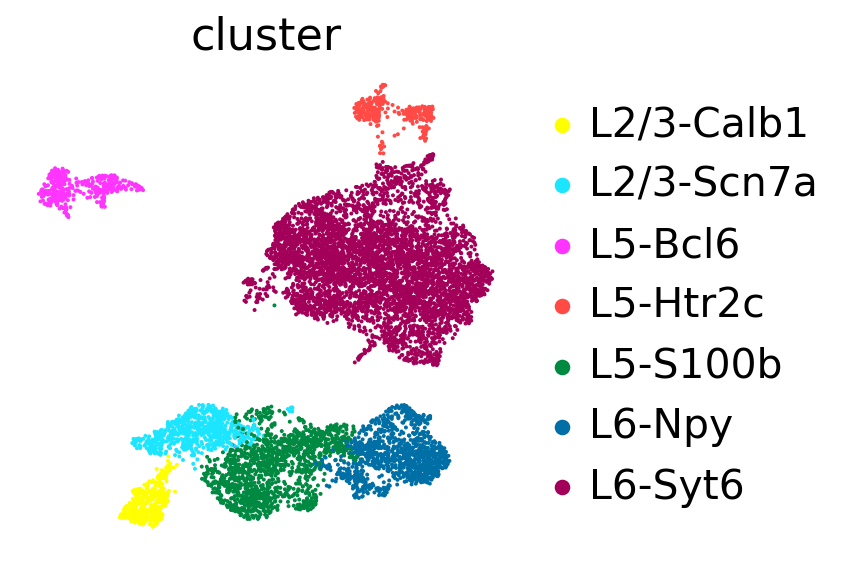

In [325]:
## check different color palletes
sc.pl.umap(bdata, color=['leiden'],use_raw=False,ncols=3,
           layer='norm_data',palette='Set1',legend_loc='right margin')
sc.pl.umap(bdata, color=['layer'],use_raw=False,ncols=3,
           layer='norm_data',palette='tab20',legend_loc='right margin')
sc.pl.umap(bdata, color=['layer_v1'],use_raw=False,ncols=3,
           layer='norm_data',palette='Accent',legend_loc='right margin')
sc.pl.umap(bdata, color=['cluster'],use_raw=False,ncols=3,
           layer='norm_data',palette=sc.pl.palettes.godsnot_102,legend_loc='right margin')


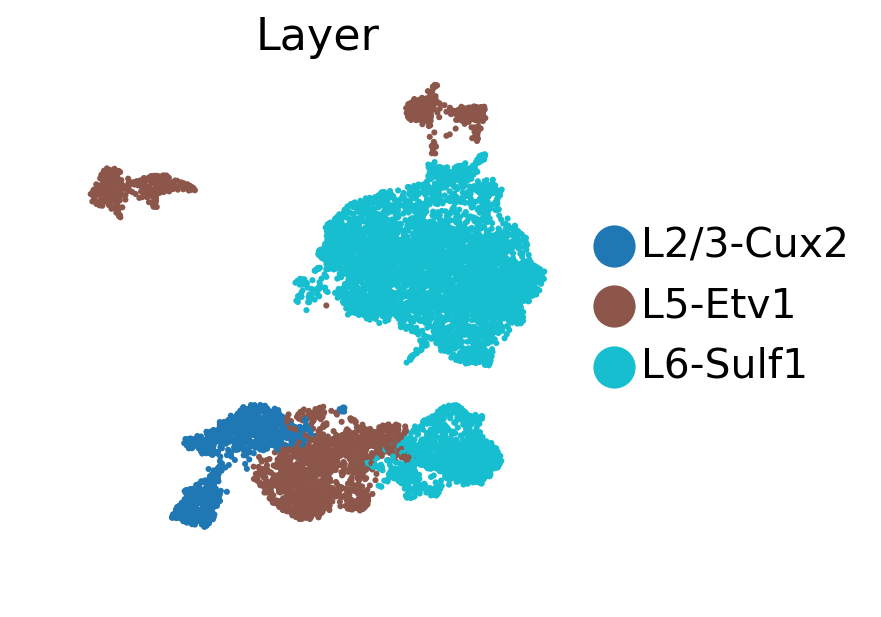

In [498]:
rcParams["legend.markerscale"] = 3.0
sc.pl.umap(bdata, color=['layer_v1'],use_raw=False,ncols=3,title='Layer',size=30,
           layer='norm_data',palette='tab10',legend_loc='right margin',save=' layer v1.pdf')

/home/xupb/anaconda3/envs/myenv/lib/python3.7/site-packages/matplotlib/backends/backend_pdf.py:939: RuntimeWarning: Glyph 0 missing from current font.
  s, flags=LOAD_NO_SCALE | LOAD_NO_HINTING).horiAdvance
/home/xupb/anaconda3/envs/myenv/lib/python3.7/site-packages/matplotlib/backends/backend_pdf.py:939: RuntimeWarning: Glyph 1 missing from current font.
  s, flags=LOAD_NO_SCALE | LOAD_NO_HINTING).horiAdvance
/home/xupb/anaconda3/envs/myenv/lib/python3.7/site-packages/matplotlib/backends/backend_pdf.py:939: RuntimeWarning: Glyph 2 missing from current font.
  s, flags=LOAD_NO_SCALE | LOAD_NO_HINTING).horiAdvance
/home/xupb/anaconda3/envs/myenv/lib/python3.7/site-packages/matplotlib/backends/backend_pdf.py:939: RuntimeWarning: Glyph 3 missing from current font.
  s, flags=LOAD_NO_SCALE | LOAD_NO_HINTING).horiAdvance
/home/xupb/anaconda3/envs/myenv/lib/python3.7/site-packages/matplotlib/backends/backend_pdf.py:939: RuntimeWarning: Glyph 4 missing from current font.
  s, flags=LOAD_NO_SC

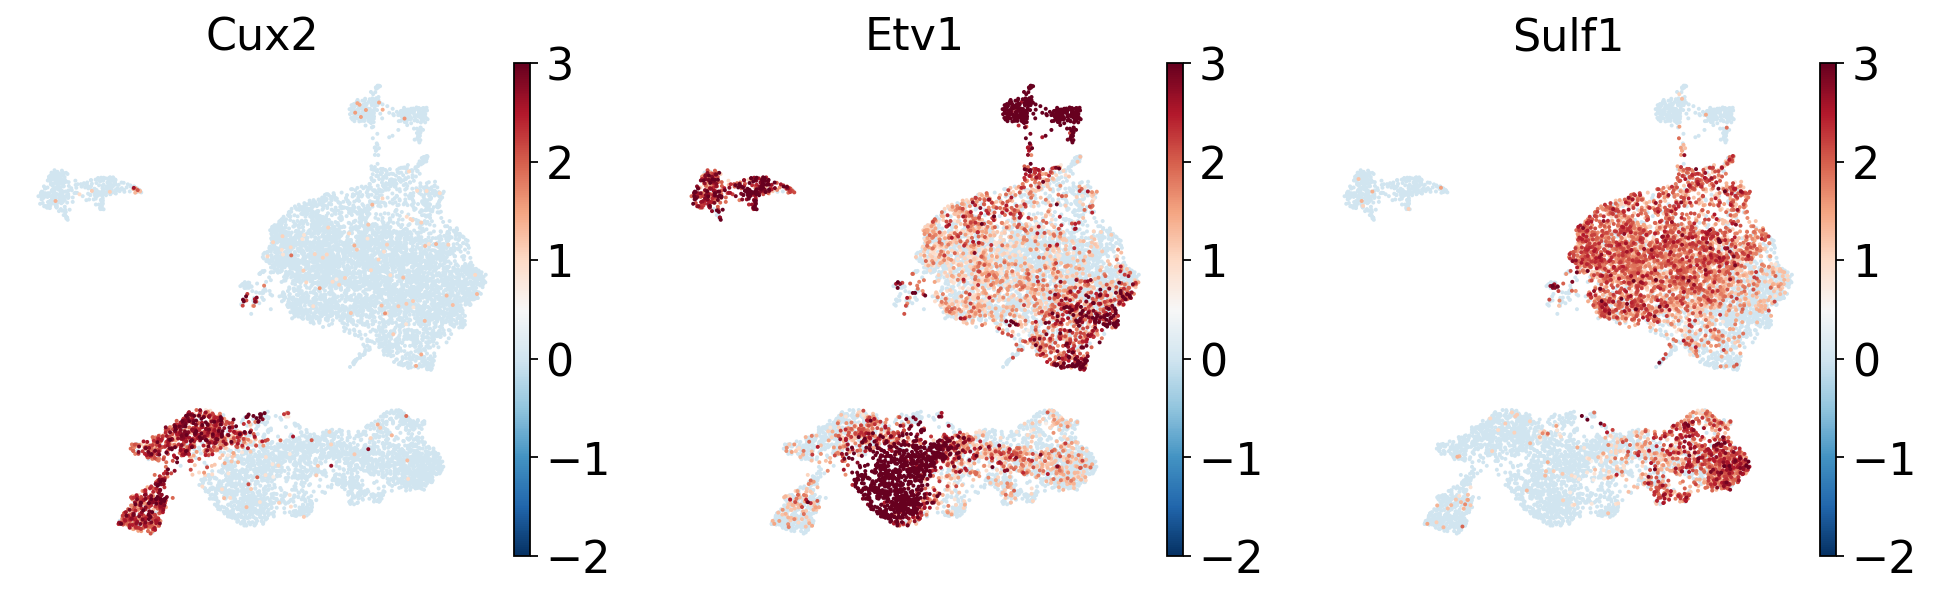

In [392]:
sc.pl.umap(bdata, color=["Cux2",#L2/3 c5 8
                         'Etv1',#L5, c3 7 9
                         'Sulf1',#L6, c0 1 4 6
                         #'Oprk1',#L6, c2
                         #"Syt6",
                       ],
           use_raw=False,ncols=3,
           color_map='RdBu_r', vmin=-2, vmax=3,
           layer='norm_data',legend_loc='on data',save=' layer genes.pdf')#

/home/xupb/anaconda3/envs/myenv/lib/python3.7/site-packages/matplotlib/backends/backend_pdf.py:939: RuntimeWarning: Glyph 0 missing from current font.
  s, flags=LOAD_NO_SCALE | LOAD_NO_HINTING).horiAdvance
/home/xupb/anaconda3/envs/myenv/lib/python3.7/site-packages/matplotlib/backends/backend_pdf.py:939: RuntimeWarning: Glyph 1 missing from current font.
  s, flags=LOAD_NO_SCALE | LOAD_NO_HINTING).horiAdvance
/home/xupb/anaconda3/envs/myenv/lib/python3.7/site-packages/matplotlib/backends/backend_pdf.py:939: RuntimeWarning: Glyph 2 missing from current font.
  s, flags=LOAD_NO_SCALE | LOAD_NO_HINTING).horiAdvance
/home/xupb/anaconda3/envs/myenv/lib/python3.7/site-packages/matplotlib/backends/backend_pdf.py:939: RuntimeWarning: Glyph 3 missing from current font.
  s, flags=LOAD_NO_SCALE | LOAD_NO_HINTING).horiAdvance
/home/xupb/anaconda3/envs/myenv/lib/python3.7/site-packages/matplotlib/backends/backend_pdf.py:939: RuntimeWarning: Glyph 4 missing from current font.
  s, flags=LOAD_NO_SC

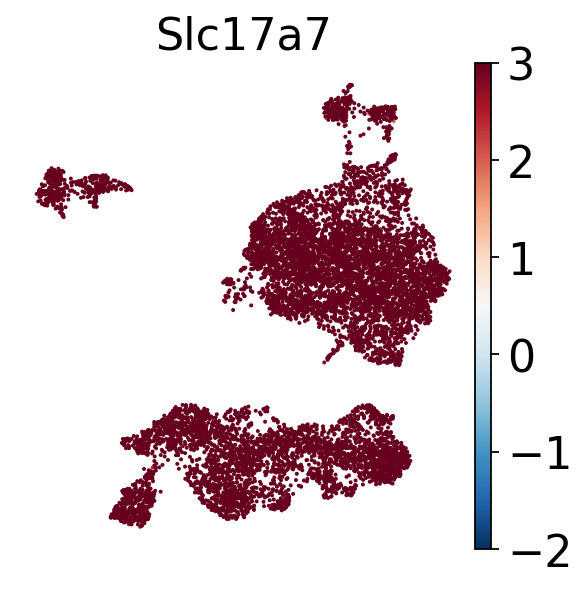

In [395]:
sc.pl.umap(bdata, color=["Slc17a7"
                       ],
           use_raw=False,ncols=3,
           color_map='RdBu_r', vmin=-2, vmax=3,
           layer='norm_data',legend_loc='on data',save=' slc17a7.pdf')#

In [98]:
# extract layer_v1 colors
bdata.uns['layer_v1_colors']

['#1f77b4', '#8c564b', '#17becf']

In [112]:
# find DEGs of leiden cluster
sc.tl.rank_genes_groups(bdata, 'leiden', method='wilcoxon',layer='norm_data',use_raw=False,n_genes=200)

ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:16)


In [113]:
pd.options.display.max_columns = None
# display max_columns setting
pd.DataFrame(bdata.uns['rank_genes_groups']['names']).head(50)

0         1              2         3          4  \
0            Pcp4       Ndn           Cnr1     Glra2    Rasl10a   
1   3110035E14Rik       Ubb        Slc24a3     Rab3b       Tesc   
2           Trbc2  Hsp90aa1          Mef2c     Ddah1      C1ql3   
3          Garnl3   Slc25a3           Nrn1  Serpini1       Enc1   
4            Rprm     Itm2b           Syn1      Cd47    Galnt14   
5           Ttc9b    Tuba1a          Kcnq3     Gap43    Tsc22d1   
6            Tle4     Gapdh  6430548M08Rik     Basp1       Dgkb   
7           Efhd2  Hsp90ab1          Nptxr       Ndn      Olfm1   
8          Ccdc12   Slc25a4         Rimbp2   Atp6ap2      Nptxr   
9          Rnf152      Mdh1           Oxr1      Lmo3        Cck   
10        Col12a1     Uchl1          Prkcb    Prss12       Nnat   
11           Tbr1      Gnas        Slc2a13     Sulf2      Nell2   
12         Slc1a2      Tecr           Stum      Cdh6      Ptprt   
13         Sema5a      Crym           Lmo4     Nxph3       Tpm1   
14          Rph3a    Tagln3            Nsf    Cldnd1   Trp53i11   
15         Hs3st4     Itm2c          Nrsn1     Uchl1       Thra   
16          Foxp2     Tusc3           Syt4    Tmsb10      Vegfd   
17          Plcb4      Rprm         Srgap3     Mctp1      Mgat5   
18         Ipcef1       Ckb           Syn2  Hsp90ab1      Opcml   
19         Snap25      Mdh2         Camk2d      Etl4      Rxfp1   
20           Lmo1    Rwdd2a         Kcnab1    Slc1a2   Sh3bgrl3   
21         Lpgat1     Aldoa          Epha4      Sdk2       Bmp3   
22          Rprml      Ldhb        Fam19a1     Sept7      Ptprk   
23         Nos1ap    Tubb2a          Timp2       Sla     Igfbp6   
24         Ccl27a     Hspa8          Celf4   Gm40518      Wipf3   
25        Pitpnc1      Cct7           Wnt4    Hs3st4     Tmsb4x   
26           Fut9    Dnaja1          Foxp1     Rab26       Rgs2   
27           Syt6     Atp5b            Ntm      Vwc2      Ccdc3   
28          Calm2    Uqcrc1          Cdh10   Phyhipl     Schip1   
29          Nxph3      Cd81           Hrh3    Pgrmc1     Col6a1   
30          Ncald     Npas4           Napb     Nrip3       Stum   
31           Pbx1     Ifi27           Nwd2    Myl12b      Oprk1   
32         Adora1     Cyth2            Cck     Rai14  Adcyap1r1   
33          Pde4d     Dusp1         Stxbp1    Tubb2a       Zeb2   
34         Plxna2     Rraga           Syt1      Cfl1     Camkk1   
35         Ndufa4    Ndufv1           Fat3    Ndufc2    Pitpnm2   
36         Adgra1       Arc         Atp1b2      Dnm3      Auts2   
37           Nrp1     Psmb1        Rapgef5      Nfia      Unc5a   
38         Pdzrn4     Psmd6          C1ql3      Mdh1     Sorcs3   
39          Nrip3       Fos          Cnih3   Tmem178      Tenm3   
40         Diras2     Psma4           Tppp      Sez6     Sema3e   
41           Nfia       Ubc        Galnt17     Foxp2    Smarca2   
42           Pfn2    Cuedc2          Kcnb2      Lsp1      Kctd4   
43          Ramp3    Atxn10          Ptprs     Arpc3     Plxna4   
44         B3gat1   Atp6ap2        Camk2n1   Pitpnc1     Sema3c   
45           Etl4      Junb         Sccpdh      Tle4       Rhou   
46         Cxcl12    Tubb4b         R3hdm1     Wasf3       Cdh9   
47           Ubl3     Psmc2        Fam126b     Actg1     Pea15a   
48          Limk1      Fdps          Ywhag     Zwint       Nav1   
49        Tmem196    Uqcrc2          Fbxw7     Efhd2    Slc20a1   

                5              6              7              8  
0           Mef2c          Pex5l         Fkbp1a          Tshz2  
1           Epha4         Pou3f1          Calb1          Lypd1  
2           Nrsn1          Rab3c        Nectin3          Cbln2  
3            Hpca         Bcl11b         Gabra2           Etv1  
4         Camk2n2          Lamp5          Itpka        Il11ra1  
5           Nr2f1         Ppfia2        Bhlhe22           Myl4  
6           Synpr          Ntng1           Cux2          Htr2c  
7            Cux2         Gabra2  2900055J20Rik          Nrsn2  
8           C

# Check markers expression of each cluster

In [552]:
bdata.obs['layer_v1'].value_counts()

L6-Sulf1     6210
L5-Etv1      2112
L2/3-Cux2    1046
Name: layer_v1, dtype: int64

# Merge cluster, coarse clustering of subtype

In [99]:

bdata.obs['cluster'] = bdata.obs['leiden']
old_to_new = {'0':'L6-Syt6','1':'L6-Syt6','3':'L6-Syt6',
              '4': 'L6-Npy',
              '5':'L2/3-Rorb','7':'L2/3-Calb1',
              '2':'L5-S100b','6':'L5-Bcl6','8':'L5-Htr2c'}
    
bdata.obs['cluster'] = (
    bdata.obs['cluster']
    .map(old_to_new)
    .astype('category')
)

In [63]:
bdata

AnnData object with n_obs × n_vars = 9368 × 19394
    obs: 'ClusterID', 'ClusterName', 'G2M_Score', 'Phase', 'S_Score', 'facs', 'nCount_RNA', 'nFeature_RNA', 'old_ident', 'orig_ident', 'percent_mt', 'percent_rp', 'sample', 'leiden', 'layer', 'cluster', 'layer_v1', 'dpt_pseudotime'
    var: 'Selected', 'vst_mean', 'vst_variable', 'vst_variance', 'vst_variance_expected', 'vst_variance_standardized', 'highly_variable'
    uns: 'cluster_colors', 'dendrogram_leiden', 'diffmap_evals', 'facs_colors', 'iroot', 'layer_colors', 'layer_v1_colors', 'leiden', 'leiden_colors', 'neighbors', 'rank_genes_groups', 'umap', 'dendrogram_layer', 'dendrogram_cluster'
    obsm: 'X_diffmap', 'X_pca', 'X_tsne', 'X_umap', 'pca_cell_embeddings', 'tsne_cell_embeddings', 'umap_cell_embeddings'
    varm: 'pca_feature_loadings'
    layers: 'norm_data', 'scale_data'
    obsp: 'distances', 'connectivities'

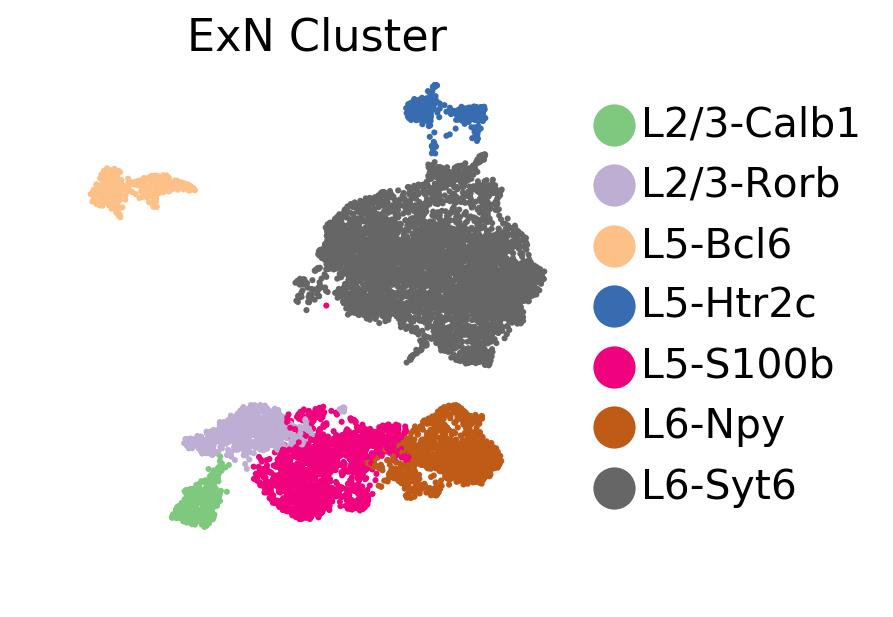

In [495]:
rcParams["legend.markerscale"] = 3.0
sc.pl.umap(bdata, color=['cluster'],use_raw=False,ncols=3,title='ExN Cluster',size=30,
           layer='norm_data',palette='Accent',legend_loc='right margin',save=' exn cluster.pdf')

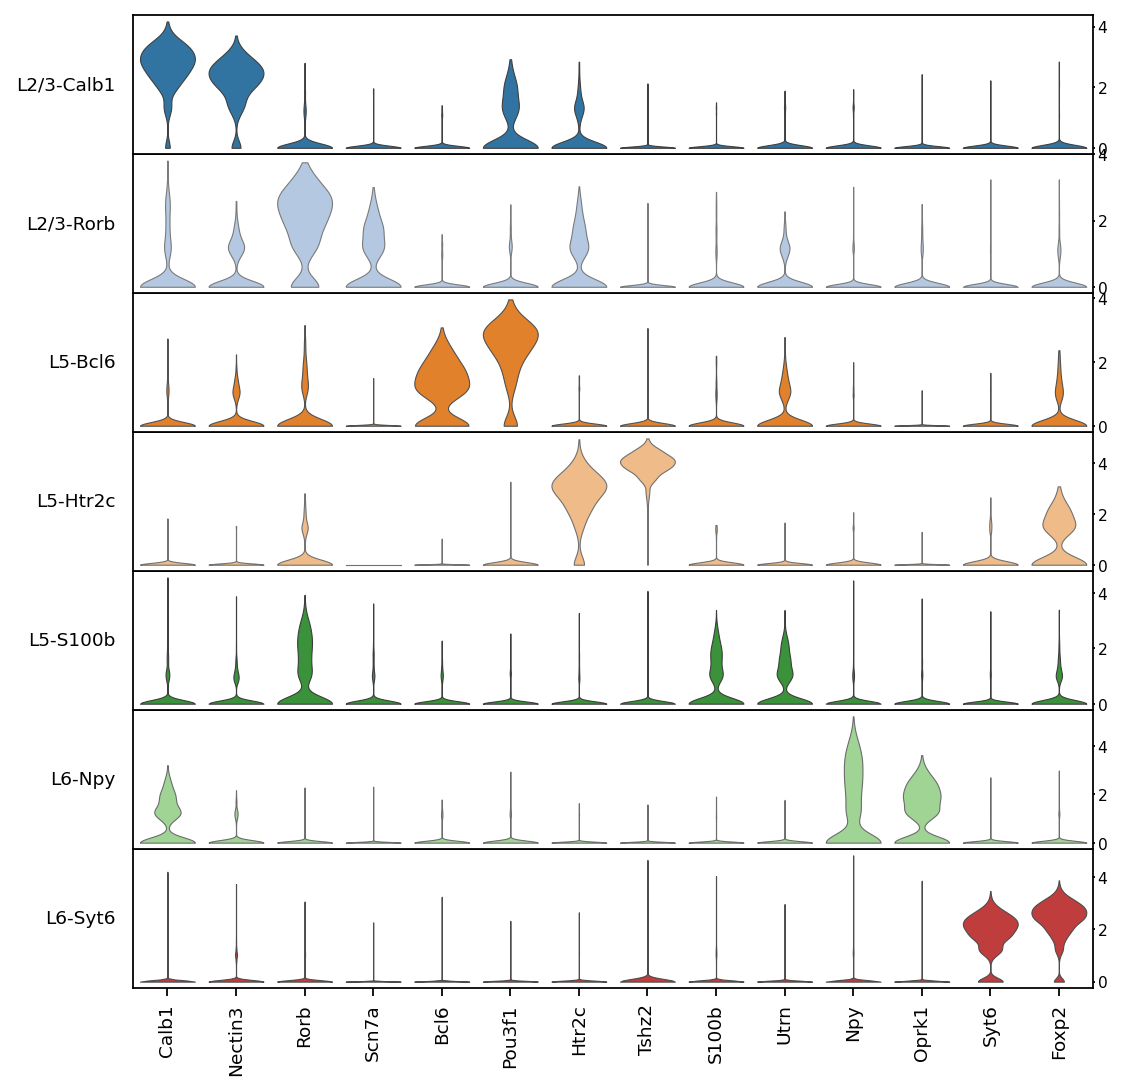

In [67]:
## violin plot of cell type markers
marker_genes=["Calb1",'Nectin3',
               'Rorb','Scn7a',
              'Bcl6','Pou3f1',
              'Htr2c','Tshz2',
            "S100b",'Utrn',
               "Npy",'Oprk1',
            'Syt6','Foxp2'
             ]
sc.pl.stacked_violin(bdata, marker_genes,layer='norm_data',
                          figsize=(8,8),row_palette=sc.pl.palettes.vega_20,
                     swap_axes=False,
                          groupby='cluster',
                     save=' exn cluster markers.pdf'
                    )

In [ ]:
bdata=sc.read_h5ad('/Users/peiboxu/Desktop/merge-seq analysis/elife_revision/data_file/pfc_sub_seu_trim_anno.h5ad')

/Users/peiboxu/mambaforge/envs/shap/lib/python3.8/site-packages/anndata/compat/__init__.py:229: FutureWarning: Moving element from .uns['neighbors']['distances'] to .obsp['distances'].

This is where adjacency matrices should go now.
  warn(
/Users/peiboxu/mambaforge/envs/shap/lib/python3.8/site-packages/anndata/compat/__init__.py:229: FutureWarning: Moving element from .uns['neighbors']['connectivities'] to .obsp['connectivities'].

This is where adjacency matrices should go now.
  warn(


In [ ]:
bdata

AnnData object with n_obs × n_vars = 9368 × 19394
    obs: 'ClusterID', 'ClusterName', 'G2M_Score', 'Phase', 'S_Score', 'facs', 'nCount_RNA', 'nFeature_RNA', 'old_ident', 'orig_ident', 'percent_mt', 'percent_rp', 'sample', 'leiden', 'layer', 'cluster', 'layer_v1', 'dpt_pseudotime'
    var: 'Selected', 'vst_mean', 'vst_variable', 'vst_variance', 'vst_variance_expected', 'vst_variance_standardized', 'highly_variable'
    uns: 'cluster_colors', 'dendrogram_leiden', 'diffmap_evals', 'facs_colors', 'iroot', 'layer_colors', 'layer_v1_colors', 'leiden', 'leiden_colors', 'neighbors', 'rank_genes_groups', 'umap'
    obsm: 'X_diffmap', 'X_pca', 'X_tsne', 'X_umap', 'pca_cell_embeddings', 'tsne_cell_embeddings', 'umap_cell_embeddings'
    varm: 'pca_feature_loadings'
    layers: 'norm_data', 'scale_data'
    obsp: 'distances', 'connectivities'

In [ ]:
exn_meta_valid_barcoded=pd.read_csv('/Users/peiboxu/Desktop/merge-seq analysis/elife_revision/results/exn_meta_valid.csv',index_col=0)
exn_meta_valid_barcoded['barcoded'].value_counts()

Non-barcoded    5319
Barcoded        2891
Name: barcoded, dtype: int64

In [ ]:
## filter adata with rows of meta_valid_barcoded ##
bdata=bdata[exn_meta_valid_barcoded.index,:]
bdata.obs=exn_meta_valid_barcoded
bdata

AnnData object with n_obs × n_vars = 8210 × 19394
    obs: 'ClusterID', 'ClusterName', 'G2M_Score', 'Phase', 'S_Score', 'facs', 'nCount_RNA', 'nFeature_RNA', 'old_ident', 'orig_ident', 'percent_mt', 'percent_rp', 'sample', 'leiden', 'layer', 'cluster', 'layer_v1', 'dpt_pseudotime', 'cluster_v1', 'barcoded', 'AI_valid', 'DMS_valid', 'MD_valid', 'BLA_valid', 'LH_valid'
    var: 'Selected', 'vst_mean', 'vst_variable', 'vst_variance', 'vst_variance_expected', 'vst_variance_standardized', 'highly_variable'
    uns: 'cluster_colors', 'dendrogram_leiden', 'diffmap_evals', 'facs_colors', 'iroot', 'layer_colors', 'layer_v1_colors', 'leiden', 'leiden_colors', 'neighbors', 'rank_genes_groups', 'umap'
    obsm: 'X_diffmap', 'X_pca', 'X_tsne', 'X_umap', 'pca_cell_embeddings', 'tsne_cell_embeddings', 'umap_cell_embeddings'
    varm: 'pca_feature_loadings'
    layers: 'norm_data', 'scale_data'
    obsp: 'distances', 'connectivities'

In [ ]:
cdata=bdata.copy()

In [ ]:
## filter cdata to only include cells whose "barcoded" value equals "Barcoded"
cdata=cdata[exn_meta_valid_barcoded['barcoded']=='Barcoded',:]

In [ ]:
cdata

View of AnnData object with n_obs × n_vars = 2891 × 19394
    obs: 'ClusterID', 'ClusterName', 'G2M_Score', 'Phase', 'S_Score', 'facs', 'nCount_RNA', 'nFeature_RNA', 'old_ident', 'orig_ident', 'percent_mt', 'percent_rp', 'sample', 'leiden', 'layer', 'cluster', 'layer_v1', 'dpt_pseudotime', 'cluster_v1', 'barcoded', 'AI_valid', 'DMS_valid', 'MD_valid', 'BLA_valid', 'LH_valid'
    var: 'Selected', 'vst_mean', 'vst_variable', 'vst_variance', 'vst_variance_expected', 'vst_variance_standardized', 'highly_variable'
    uns: 'cluster_colors', 'dendrogram_leiden', 'diffmap_evals', 'facs_colors', 'iroot', 'layer_colors', 'layer_v1_colors', 'leiden', 'leiden_colors', 'neighbors', 'rank_genes_groups', 'umap'
    obsm: 'X_diffmap', 'X_pca', 'X_tsne', 'X_umap', 'pca_cell_embeddings', 'tsne_cell_embeddings', 'umap_cell_embeddings'
    varm: 'pca_feature_loadings'
    layers: 'norm_data', 'scale_data'
    obsp: 'distances', 'connectivities'

/Users/peiboxu/opt/anaconda3/envs/shap/lib/python3.10/site-packages/anndata/_core/anndata.py:1222: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/Users/peiboxu/opt/anaconda3/envs/shap/lib/python3.10/site-packages/anndata/_core/anndata.py:1222: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/Users/peiboxu/opt/anaconda3/envs/shap/lib/python3.10/site-packages/anndata/_core/anndata.py:1222: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/Users/peiboxu/opt/anaconda3/envs/shap/lib/python3.10/site-packages/anndata/_core/anndata.py:1222: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/Users/peiboxu/opt/anaconda3/envs/shap/lib/python3.10/site-packages/anndata/_core/anndata.py:1222: ImplicitModificationWarning: Trying to modify

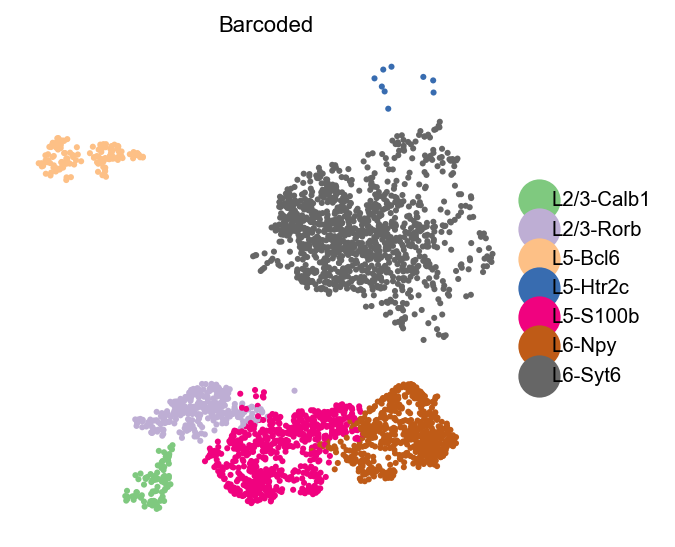

In [ ]:
rcParams["legend.markerscale"] = 3.0
sc.pl.umap(cdata, color=['cluster'],use_raw=False,ncols=3,title='Barcoded',size=30,
           layer='norm_data',palette='Accent',legend_loc='right margin',save=' fig2 exn cluster barcoded.pdf')

/Users/peiboxu/opt/anaconda3/envs/shap/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  cax = scatter(
/Users/peiboxu/opt/anaconda3/envs/shap/lib/python3.10/site-packages/scanpy/plotting/_utils.py:430: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns[value_to_plot + '_colors'] = colors_list


/Users/peiboxu/opt/anaconda3/envs/shap/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


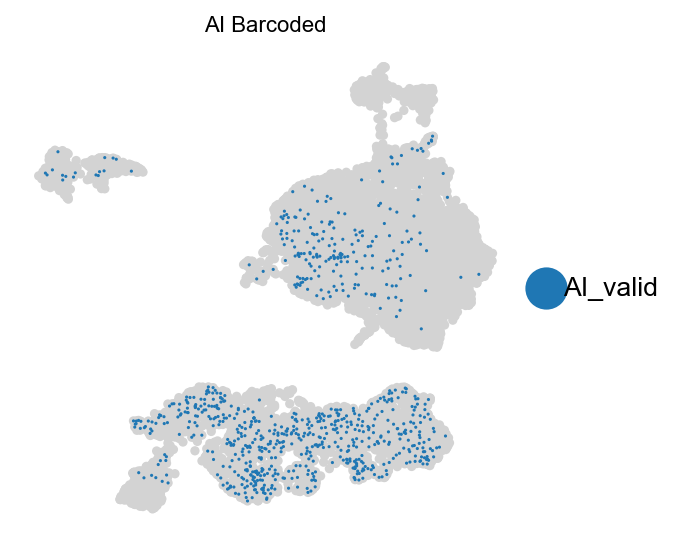

/Users/peiboxu/opt/anaconda3/envs/shap/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  cax = scatter(
/Users/peiboxu/opt/anaconda3/envs/shap/lib/python3.10/site-packages/scanpy/plotting/_utils.py:430: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns[value_to_plot + '_colors'] = colors_list


/Users/peiboxu/opt/anaconda3/envs/shap/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


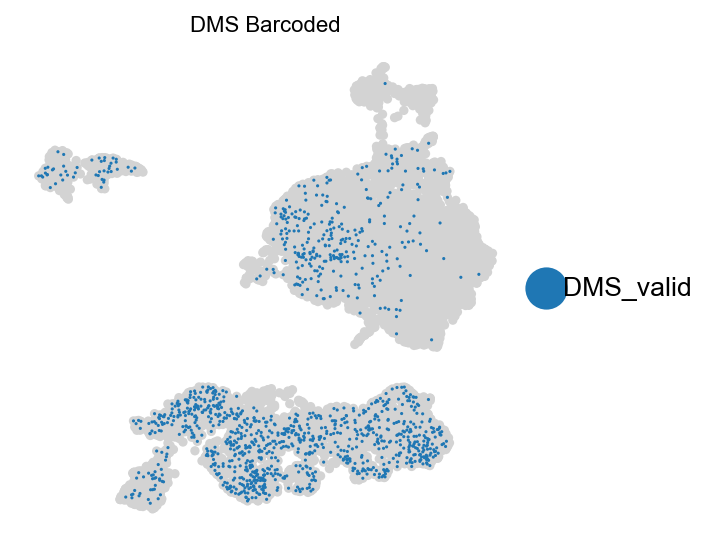

/Users/peiboxu/opt/anaconda3/envs/shap/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  cax = scatter(
/Users/peiboxu/opt/anaconda3/envs/shap/lib/python3.10/site-packages/scanpy/plotting/_utils.py:430: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns[value_to_plot + '_colors'] = colors_list
/Users/peiboxu/opt/anaconda3/envs/shap/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


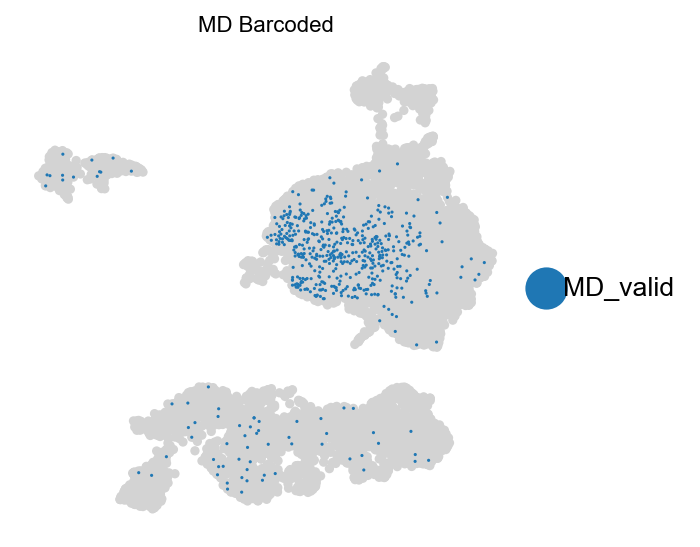

/Users/peiboxu/opt/anaconda3/envs/shap/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  cax = scatter(
/Users/peiboxu/opt/anaconda3/envs/shap/lib/python3.10/site-packages/scanpy/plotting/_utils.py:430: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns[value_to_plot + '_colors'] = colors_list
/Users/peiboxu/opt/anaconda3/envs/shap/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


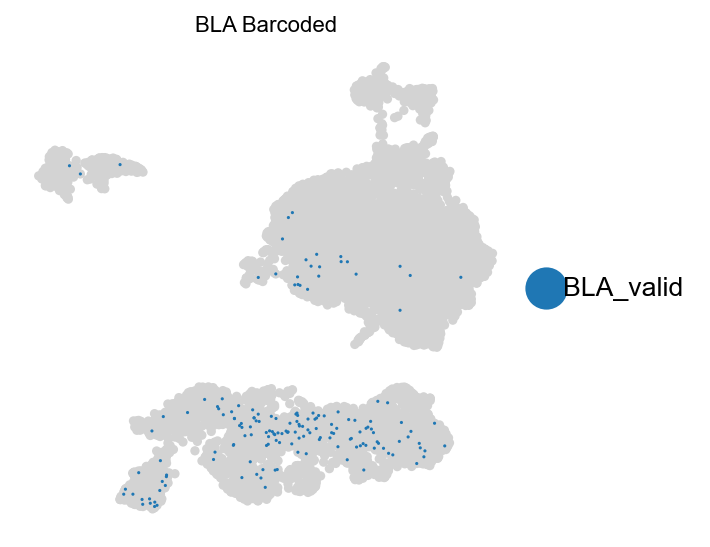

/Users/peiboxu/opt/anaconda3/envs/shap/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  cax = scatter(
/Users/peiboxu/opt/anaconda3/envs/shap/lib/python3.10/site-packages/scanpy/plotting/_utils.py:430: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns[value_to_plot + '_colors'] = colors_list
/Users/peiboxu/opt/anaconda3/envs/shap/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


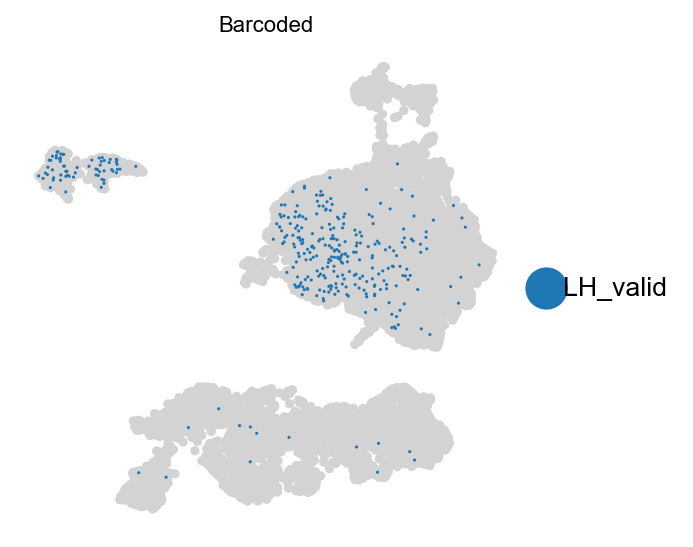

In [ ]:
### plot a umap of all cells, colored by "AI_valid", when "Others" cells are grey
ax = sc.pl.umap(bdata, size=70, show=False)
rcParams["legend.markerscale"] = 3.0
sc.pl.umap(
    bdata[bdata.obs["AI_valid"] == "AI_valid"],
    size=8,
    color='AI_valid',title='AI Barcoded',legend_fontsize ='large',
    ax=ax,
    save=' fig2 exn AI barcoded cells.pdf'
)

### plot a umap of all cells, colored by "AI_valid", when "Others" cells are grey
ax = sc.pl.umap(bdata, size=70, show=False)
rcParams["legend.markerscale"] = 3.0
sc.pl.umap(
    bdata[bdata.obs["DMS_valid"] == "DMS_valid"],
    size=8,
    color='DMS_valid',title='DMS Barcoded',legend_fontsize ='large',
    ax=ax,
    save=' fig2 exn DMS barcoded cells.pdf'
)

### plot a umap of all cells, colored by "AI_valid", when "Others" cells are grey
ax = sc.pl.umap(bdata, size=70, show=False)
rcParams["legend.markerscale"] = 3.0
sc.pl.umap(
    bdata[bdata.obs["MD_valid"] == "MD_valid"],
    size=8,
    color='MD_valid',title='MD Barcoded',legend_fontsize ='large',
    ax=ax,
    save=' fig2 exn MD barcoded cells.pdf'
)

### plot a umap of all cells, colored by "AI_valid", when "Others" cells are grey
ax = sc.pl.umap(bdata, size=70, show=False)
rcParams["legend.markerscale"] = 3.0
sc.pl.umap(
    bdata[bdata.obs["BLA_valid"] == "BLA_valid"],
    size=8,
    color='BLA_valid',title='BLA Barcoded',legend_fontsize ='large',
    ax=ax,
    save=' fig2 exn BLA barcoded cells.pdf'
)

### plot a umap of all cells, colored by "AI_valid", when "Others" cells are grey
ax = sc.pl.umap(bdata, size=70, show=False)
rcParams["legend.markerscale"] = 3.0
sc.pl.umap(
    bdata[bdata.obs["LH_valid"] == "LH_valid"],
    size=8,
    color='LH_valid',title='Barcoded',legend_fontsize ='large',
    ax=ax,
    save=' fig2 exn LH barcoded cells.pdf'
)


/home/xupb/anaconda3/envs/myenv/lib/python3.7/site-packages/matplotlib/backends/backend_pdf.py:939: RuntimeWarning: Glyph 0 missing from current font.
  s, flags=LOAD_NO_SCALE | LOAD_NO_HINTING).horiAdvance
/home/xupb/anaconda3/envs/myenv/lib/python3.7/site-packages/matplotlib/backends/backend_pdf.py:939: RuntimeWarning: Glyph 1 missing from current font.
  s, flags=LOAD_NO_SCALE | LOAD_NO_HINTING).horiAdvance
/home/xupb/anaconda3/envs/myenv/lib/python3.7/site-packages/matplotlib/backends/backend_pdf.py:939: RuntimeWarning: Glyph 2 missing from current font.
  s, flags=LOAD_NO_SCALE | LOAD_NO_HINTING).horiAdvance
/home/xupb/anaconda3/envs/myenv/lib/python3.7/site-packages/matplotlib/backends/backend_pdf.py:939: RuntimeWarning: Glyph 3 missing from current font.
  s, flags=LOAD_NO_SCALE | LOAD_NO_HINTING).horiAdvance
/home/xupb/anaconda3/envs/myenv/lib/python3.7/site-packages/matplotlib/backends/backend_pdf.py:939: RuntimeWarning: Glyph 4 missing from current font.
  s, flags=LOAD_NO_SC

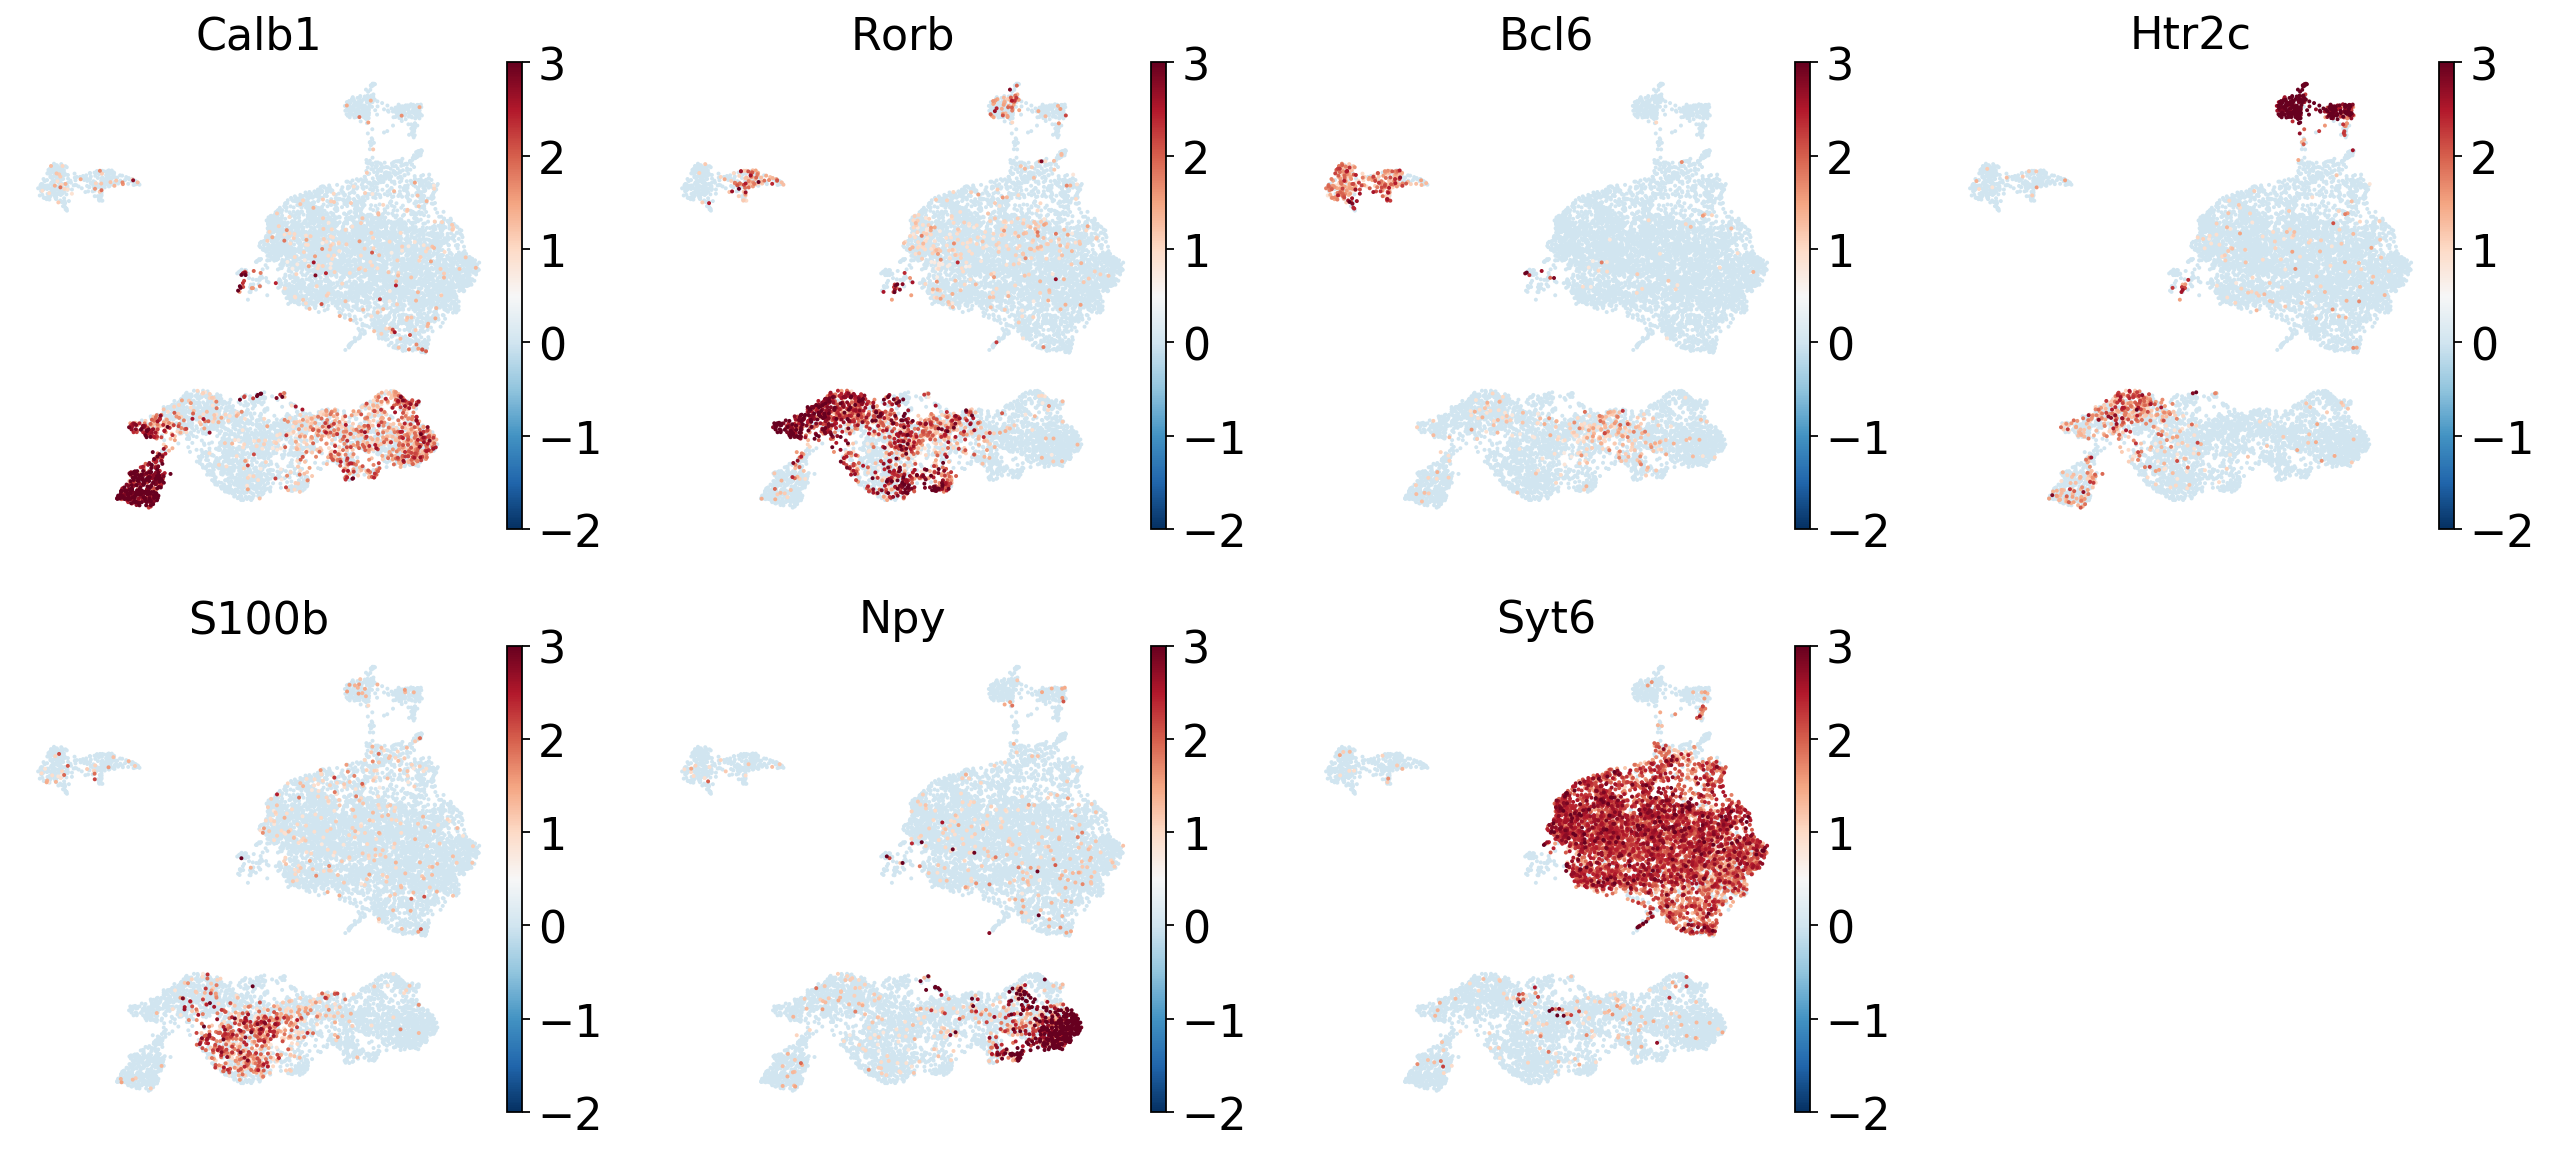

In [399]:
sc.pl.umap(bdata, color=["Calb1",'Rorb','Bcl6','Htr2c','S100b','Npy','Syt6'],
           use_raw=False,ncols=4,
           color_map='RdBu_r', vmin=-2, vmax=3,
           layer='norm_data',legend_loc='on data',save=' cluster marker genes.pdf')#

In [11]:
sc.tl.dendrogram(bdata,groupby='cluster')

    using 'X_pca' with n_pcs = 50
Storing dendrogram info using `.uns['dendrogram_cluster']`


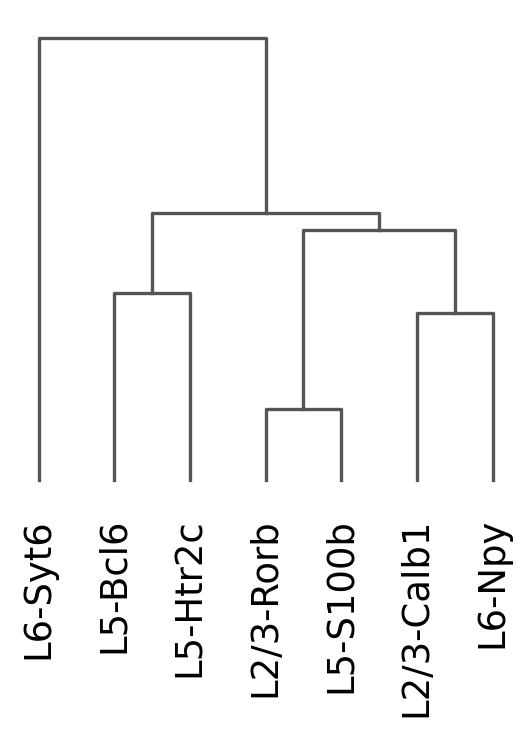

In [12]:
 sc.pl.dendrogram(bdata,groupby='cluster')

In [161]:
# export meta info
bdata.obs.to_csv('sub_exn_trim_meta.csv')

In [10]:
# extract cluster colors
bdata.uns['cluster_colors']

array(['#7fc97f', '#beaed4', '#fdc086', '#386cb0', '#f0027f', '#bf5b17',
       '#666666'], dtype=object)

In [9]:
# extract layer colors
bdata.uns['layer_v1_colors']

['#1f77b4', '#8c564b', '#17becf']

In [503]:
# extract cluster names
bdata.obs['cluster'].cat.categories

Index(['L2/3-Calb1', 'L2/3-Rorb', 'L5-Bcl6', 'L5-Htr2c', 'L5-S100b', 'L6-Npy',
       'L6-Syt6'],
      dtype='object')

In [210]:
# extract layer names
bdata.obs['layer_v1'].cat.categories

Index(['L2/3-Cux2', 'L5-Etv1', 'L6-Sulf1'], dtype='object')

In [602]:
# check points, save file
results_file = './write/pfc_sub_seu_trim_anno.h5ad'
bdata.write(results_file) 

In [7]:
bdata=sc.read_h5ad('./write/pfc_sub_seu_trim_anno.h5ad')

/home/xupb/anaconda3/envs/myenv/lib/python3.7/site-packages/anndata/compat/__init__.py:161: FutureWarning: Moving element from .uns['neighbors']['distances'] to .obsp['distances'].

This is where adjacency matrices should go now.
  FutureWarning,
/home/xupb/anaconda3/envs/myenv/lib/python3.7/site-packages/anndata/compat/__init__.py:161: FutureWarning: Moving element from .uns['neighbors']['connectivities'] to .obsp['connectivities'].

This is where adjacency matrices should go now.
  FutureWarning,
